In [10]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder.appName('JSON Handling').getOrCreate()

#Each json file is a single record. If we want to ingest multiple lines across documents then set multiLine = True
shows = spark.read.json("data/DataAnalysisWithPythonAndPySpark-Data-trunk/shows/*.json",multiLine = True)

shows.count()

#Container type or Compound data types or complex data types are types that contain other types 
#Ex - Array,Map,Struct in pyspark

print(shows.printSchema())
print(shows.columns)


root
 |-- _embedded: struct (nullable = true)
 |    |-- episodes: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- _links: struct (nullable = true)
 |    |    |    |    |-- self: struct (nullable = true)
 |    |    |    |    |    |-- href: string (nullable = true)
 |    |    |    |-- airdate: string (nullable = true)
 |    |    |    |-- airstamp: string (nullable = true)
 |    |    |    |-- airtime: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- image: struct (nullable = true)
 |    |    |    |    |-- medium: string (nullable = true)
 |    |    |    |    |-- original: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- number: long (nullable = true)
 |    |    |    |-- runtime: long (nullable = true)
 |    |    |    |-- season: long (nullable = true)
 |    |    |    |-- summary: string (nullable = true)
 |    |    |    |-- url: string (nullable = true

In [37]:
#Small Exercises - 
"""{"name": "Sample name",
"keywords": ["PySpark", "Python", "Data"]}"""

sample = spark.read.json("data/6.1.json")
sample.printSchema()

"""{"name": "Sample name",
"keywords": ["PySpark", 3.2, "Data"]}"""
sample = spark.read.json("data/6.2.json")
sample.printSchema()


root
 |-- keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- name: string (nullable = true)

root
 |-- keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- name: string (nullable = true)



#### Container type or Compound data types are complex data types 
######  Types that contain other types such as below :-
* Array
* Map
* Struct

### Array Type
* Pyspark arrays are different from python lists in a way that it can only contain values of same data types

In [25]:
#Exploring Data
array_subset = shows.select("name","genres")
array_size = array_subset
array_subset.show(5,False)

#Different ways to acess arrays inside cell
array_subset = array_subset.select(
"name",
array_subset.genres[0].alias("dot_and_index"),
F.col("genres")[0].alias("col_and_index"),
array_subset.genres.getItem(0).alias("dot_and_method"),
F.col("genres").getItem(0).alias("col_and_method"),
)
array_subset.show()


#Performing multiple operation on array column
array_subset_repeated = array_subset.select(
"name",
F.lit("Comedy").alias("one"), #lit creates a column with value , in this column "one" is created with values "Comedy"
F.lit("Horror").alias("two"),
F.lit("Drama").alias("three"),
F.col("dot_and_index"),
).select(
"name",
# "one",
# "two",
# "three"
F.array("one", "two", "three").alias("Some_Genres"), #Creating array from three columns using array function
F.array_repeat("dot_and_index", 5).alias("Repeated_Genres"), # Duplicating values five times within an array
)
array_subset_repeated.show(5,False)


#Remove duplicates from arrays
array_subset_repeated.select(
"name",
F.array_distinct("Some_Genres"),
F.array_distinct("Repeated_Genres"),
).show(5,False)


#intersecting both arrays using array_intersect()
array_subset_repeated = array_subset_repeated.select(
"name",
F.array_intersect("Some_Genres", "Repeated_Genres").alias(
"Genres"
),
)

array_subset_repeated.show()

#Using Arrays postions to search "Comedy" (value) in "Genres" columns. 
#If a match is not found then value is 0, if it is found then it is the index in the array.
#Note - 0 represents absence and not the index ,occurence of value at 0th index will be represented by 1
array_subset_repeated.select(
"Genres", F.array_position("Genres", "Comedy")
).show()

#Get sizes of array 
array_size.select(
"name", F.size("Genres").alias("Size of Genre Array")
).show()

+----------------+------------------------+
|name            |genres                  |
+----------------+------------------------+
|The Golden Girls|[Drama, Comedy]         |
|Breaking Bad    |[Drama, Crime, Thriller]|
|Silicon Valley  |[Comedy]                |
+----------------+------------------------+

+----------------+-------------+-------------+--------------+--------------+
|            name|dot_and_index|col_and_index|dot_and_method|col_and_method|
+----------------+-------------+-------------+--------------+--------------+
|The Golden Girls|        Drama|        Drama|         Drama|         Drama|
|    Breaking Bad|        Drama|        Drama|         Drama|         Drama|
|  Silicon Valley|       Comedy|       Comedy|        Comedy|        Comedy|
+----------------+-------------+-------------+--------------+--------------+

+----------------+-----------------------+----------------------------------------+
|name            |Some_Genres            |Repeated_Genres          

### Map
* Like Python dictionary:keys and 
value format
* Keys and value needs to be of same types).

In [31]:
#Creating Map from two arrays
columns = ["name", "language", "type"]
shows_map = shows.select(
*[F.lit(column) for column in columns],
F.array(*columns).alias("values"),
)
shows_map = shows_map.select(F.array(*columns).alias("keys"), "values")
shows_map.show(1,False)

shows_map = shows_map.select(
F.map_from_arrays("keys", "values").alias("mapped")
)
shows_map.printSchema()
shows_map.show(5,False)

#Accessing key values
shows_map.select(
F.col("mapped.name"),
F.col("mapped")["name"],
shows_map.mapped["name"],
).show()

+----------------------+-------------------------------------+
|keys                  |values                               |
+----------------------+-------------------------------------+
|[name, language, type]|[The Golden Girls, English, Scripted]|
+----------------------+-------------------------------------+
only showing top 1 row

root
 |-- mapped: map (nullable = false)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)

+-----------------------------------------------------------------+
|mapped                                                           |
+-----------------------------------------------------------------+
|{name -> The Golden Girls, language -> English, type -> Scripted}|
|{name -> Breaking Bad, language -> English, type -> Scripted}    |
|{name -> Silicon Valley, language -> English, type -> Scripted}  |
+-----------------------------------------------------------------+

+----------------+----------------+----------------+
|            nam

#### NOTE - 
valueContainsNull is optional parameter in array or maps that tells if array or map contain can accept null elements. This is different than the nullable flag at column level:

### STRUCT

* It is like JSON Object
* The array and the map enforce the types 
of the values, but not their numbers or names. The struct allows for more versatilit 
of types, as long as you name each field and provide the type ahead of time.


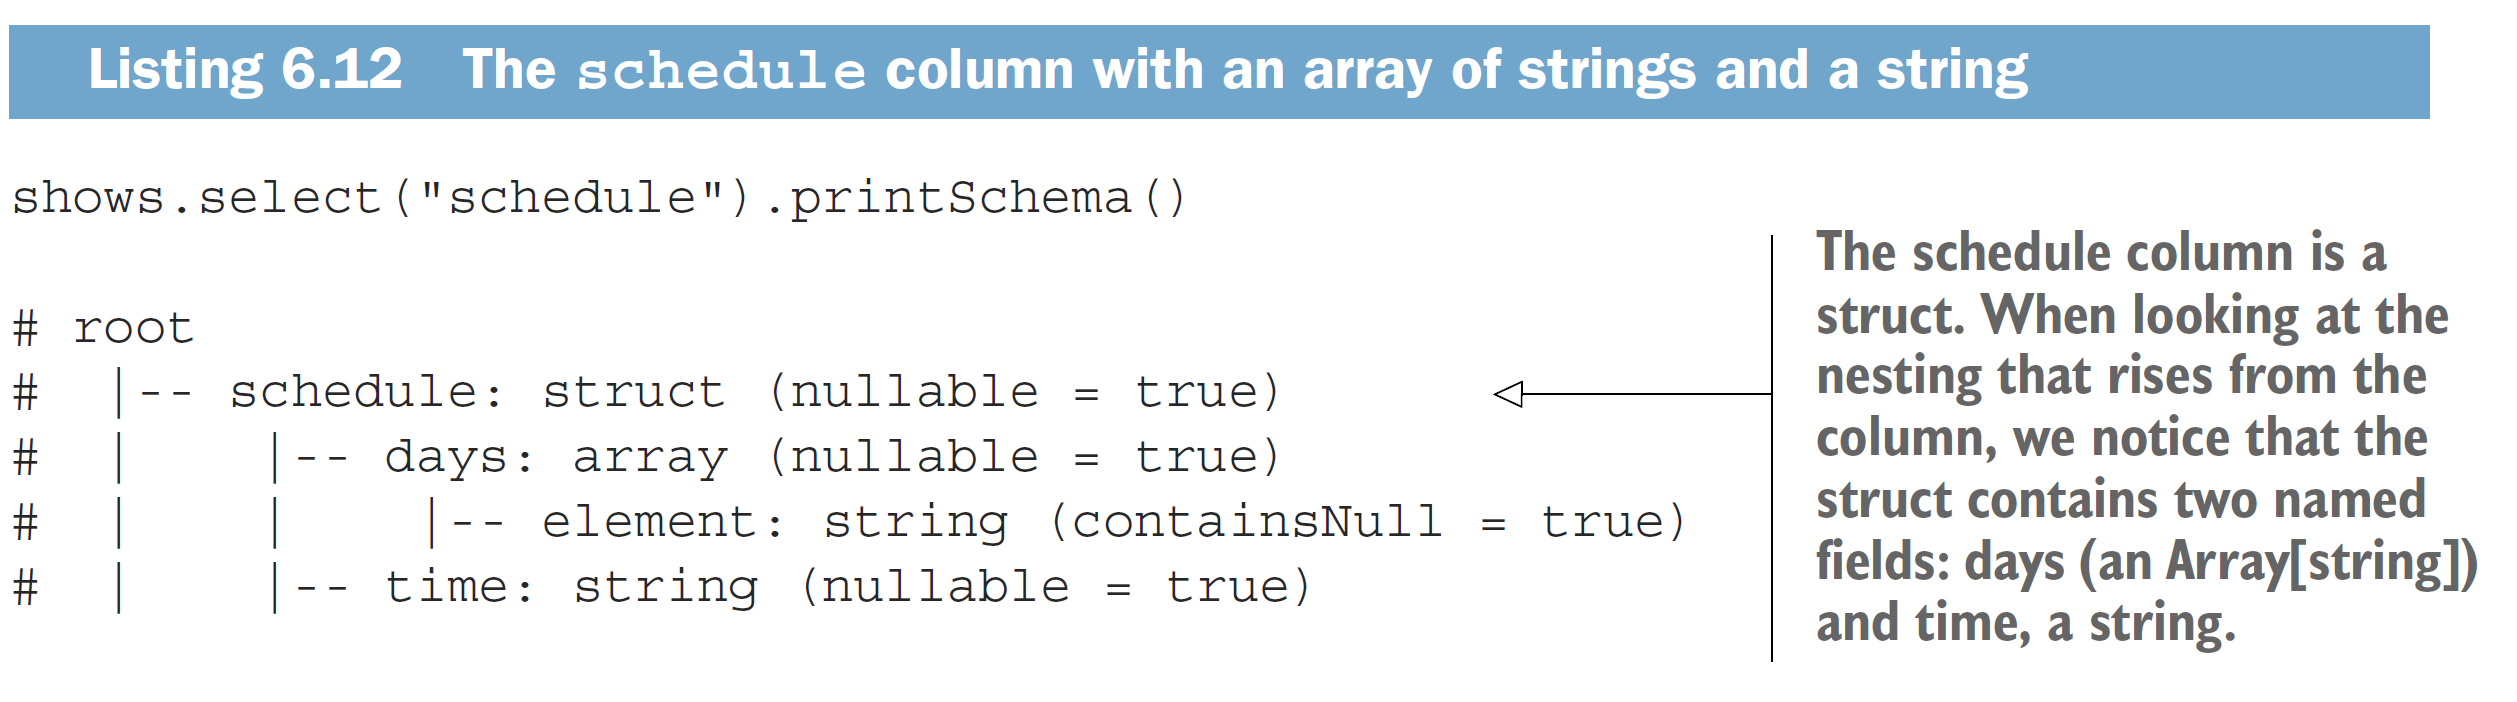

In [40]:
shows.select(F.col("_embedded")).printSchema()

root
 |-- _embedded: struct (nullable = true)
 |    |-- episodes: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- _links: struct (nullable = true)
 |    |    |    |    |-- self: struct (nullable = true)
 |    |    |    |    |    |-- href: string (nullable = true)
 |    |    |    |-- airdate: string (nullable = true)
 |    |    |    |-- airstamp: string (nullable = true)
 |    |    |    |-- airtime: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- image: struct (nullable = true)
 |    |    |    |    |-- medium: string (nullable = true)
 |    |    |    |    |-- original: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- number: long (nullable = true)
 |    |    |    |-- runtime: long (nullable = true)
 |    |    |    |-- season: long (nullable = true)
 |    |    |    |-- summary: string (nullable = true)
 |    |    |    |-- url: string (nullable = true

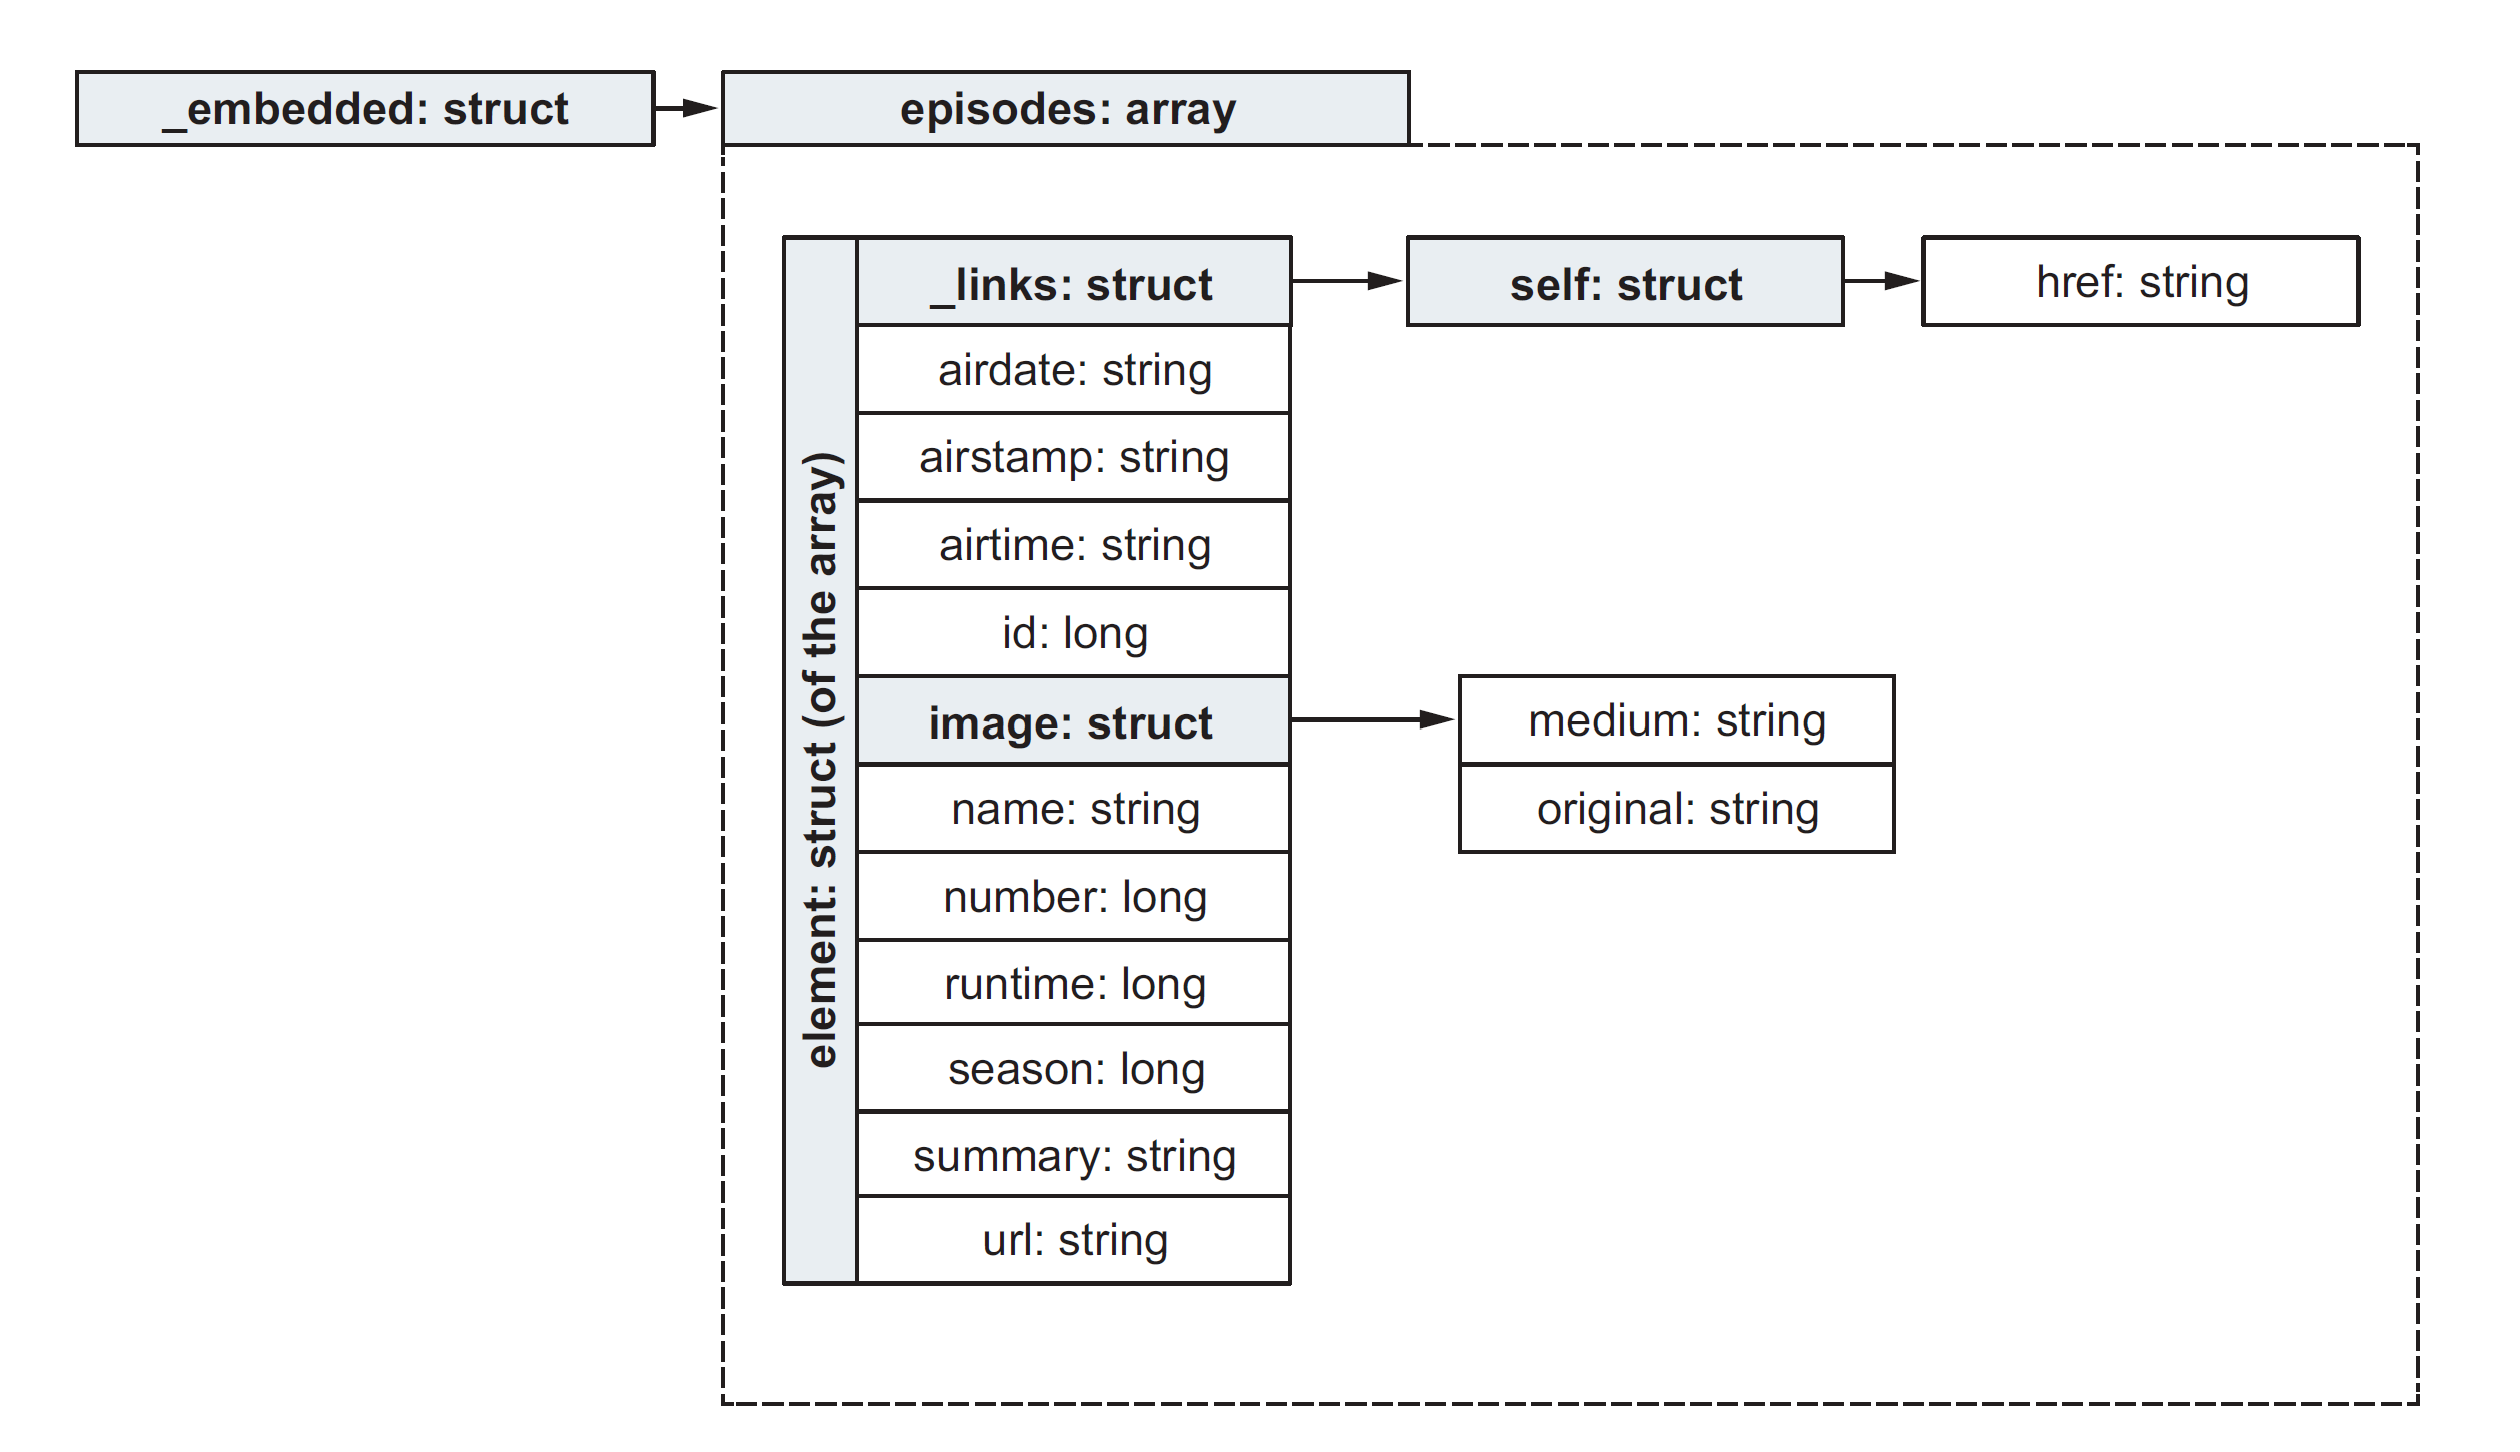

In [46]:
shows_clean = shows.withColumn(
"episodes", F.col("_embedded.episodes")
).drop("_embedded")

shows_clean.printSchema()  #We lost the _embedded column and promoted the field of the struct (episodes) as a toplevel column.

#Selecting a field in an Array[Struct] to create column
episodes_name = shows_clean.select(F.col("episodes.name"))
episodes_name.printSchema()

episodes_name.select(F.explode("name").alias("name")).show(3,False)


root
 |-- _links: struct (nullable = true)
 |    |-- previousepisode: struct (nullable = true)
 |    |    |-- href: string (nullable = true)
 |    |-- self: struct (nullable = true)
 |    |    |-- href: string (nullable = true)
 |-- externals: struct (nullable = true)
 |    |-- imdb: string (nullable = true)
 |    |-- thetvdb: long (nullable = true)
 |    |-- tvrage: long (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- medium: string (nullable = true)
 |    |-- original: string (nullable = true)
 |-- language: string (nullable = true)
 |-- name: string (nullable = true)
 |-- network: struct (nullable = true)
 |    |-- country: struct (nullable = true)
 |    |    |-- code: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- timezone: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nul

In [54]:
#Creating custom schema of structs
import pyspark.sql.types as T

episode_links_schema = T.StructType(
[T.StructField(
"self", T.StructType([T.StructField("href", T.StringType())])
)
]
)
print(episode_links_schema)

episode_image_schema = T.StructType(
[
T.StructField("medium", T.StringType()),
T.StructField("original", T.StringType()),
]
)

print(episode_image_schema)


episode_schema = T.StructType(
[
T.StructField("_links", episode_links_schema),
T.StructField("airdate", T.DateType()),
T.StructField("airstamp", T.TimestampType()),
T.StructField("airtime", T.StringType()),
T.StructField("id", T.StringType()),
T.StructField("image", episode_image_schema),
T.StructField("name", T.StringType()),
T.StructField("number", T.LongType()),
T.StructField("runtime", T.LongType()),
T.StructField("season", T.LongType()),
T.StructField("summary", T.StringType()),
T.StructField("url", T.StringType()),
]
)

embedded_schema = T.StructType(
[
T.StructField(
"_embedded",
T.StructType(
[
T.StructField(
"episodes", T.ArrayType(episode_schema)
)
]
),
)
]
)
print("##################################")
print(embedded_schema)

StructType([StructField('self', StructType([StructField('href', StringType(), True)]), True)])
StructType([StructField('medium', StringType(), True), StructField('original', StringType(), True)])
##################################
StructType([StructField('_embedded', StructType([StructField('episodes', ArrayType(StructType([StructField('_links', StructType([StructField('self', StructType([StructField('href', StringType(), True)]), True)]), True), StructField('airdate', DateType(), True), StructField('airstamp', TimestampType(), True), StructField('airtime', StringType(), True), StructField('id', StringType(), True), StructField('image', StructType([StructField('medium', StringType(), True), StructField('original', StringType(), True)]), True), StructField('name', StringType(), True), StructField('number', LongType(), True), StructField('runtime', LongType(), True), StructField('season', LongType(), True), StructField('summary', StringType(), True), StructField('url', StringType(), True

In [60]:
#Reading file into a custom schema that we wrote above

shows_with_schema = spark.read.json(
"data/DataAnalysisWithPythonAndPySpark-Data-trunk/shows/shows-silicon-valley.json",
schema=embedded_schema, ##We pass our schema to the schema parameter. Since our schema is a subset of the JSON document, we only read the defined fields.
 mode="FAILFAST" #selecting the FAILFAST mode, our DataFrameReader will crash if our schema is incompatible.
)

for column in ["airdate", "airstamp"]:
    shows.select(f"_embedded.episodes.{column}").select(
    F.explode(column)
).show(5)


+----------+
|       col|
+----------+
|1985-09-14|
|1985-09-21|
|1985-09-28|
|1985-10-05|
|1985-10-19|
+----------+
only showing top 5 rows

+--------------------+
|                 col|
+--------------------+
|1985-09-15T01:00:...|
|1985-09-22T01:00:...|
|1985-09-29T01:00:...|
|1985-10-06T01:00:...|
|1985-10-20T01:00:...|
+--------------------+
only showing top 5 rows



In [62]:
#Making a Bad Schema and then Checking the results

from py4j.protocol import Py4JJavaError
episode_schema_BAD = T.StructType(
[
T.StructField("_links", episode_links_schema),
T.StructField("airdate", T.DateType()),
T.StructField("airstamp", T.TimestampType()),
T.StructField("airtime", T.StringType()),
T.StructField("id", T.StringType()),
T.StructField("image", episode_image_schema),
T.StructField("name", T.StringType()),
T.StructField("number", T.LongType()),
T.StructField("runtime", T.LongType()),
T.StructField("season", T.LongType()),
T.StructField("summary", T.LongType()),
T.StructField("url", T.LongType()),
]
)

embedded_schema2 = T.StructType(
[
T.StructField(
"_embedded",
T.StructType(
[
T.StructField(
"episodes", T.ArrayType(episode_schema_BAD)
)
]
),
)
]
)

shows_with_schema_wrong = spark.read.json(
"data/DataAnalysisWithPythonAndPySpark-Data-trunk/shows/shows-silicon-valley.json",
schema=embedded_schema2,
mode="FAILFAST",
)


try:
    shows_with_schema_wrong.show()
except Py4JJavaError:
    pass

23/10/18 16:06:44 ERROR Executor: Exception in task 0.0 in stage 183.0 (TID 265)
org.apache.spark.SparkException: Encountered error while reading file file:///home/shravan/source_code/data/DataAnalysisWithPythonAndPySpark-Data-trunk/shows/shows-silicon-valley.json. Details:
	at org.apache.spark.sql.errors.QueryExecutionErrors$.cannotReadFilesError(QueryExecutionErrors.scala:863)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:293)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCode

In [73]:
import pprint
import json

pprint.pprint(
    shows_with_schema.select(
    F.explode("_embedded.episodes").alias("episode")
).select("episode.airtime")
.schema.jsonValue()
)

print("###############################")

pprint.pprint(
T.StructField("array_example", T.ArrayType(T.StringType())).jsonValue()
)

print("###############################")

pprint.pprint(
T.StructField(
"map_example", T.MapType(T.StringType(), T.LongType())
).jsonValue()
)

print("####################################")

pprint.pprint(
T.StructType(
[
T.StructField(
"map_example", T.MapType(T.StringType(), T.LongType())
),
T.StructField("array_example", T.ArrayType(T.StringType())),
]
).jsonValue()
)

#Validation JSON schema is equal to data frame schema
other_shows_schema = T.StructType.fromJson(
json.loads(shows_with_schema.schema.json())
)
print(other_shows_schema == shows_with_schema.schema)

{'fields': [{'metadata': {},
             'name': 'airtime',
             'nullable': True,
             'type': 'string'}],
 'type': 'struct'}
###############################
{'metadata': {},
 'name': 'array_example',
 'nullable': True,
 'type': {'containsNull': True, 'elementType': 'string', 'type': 'array'}}
###############################
{'metadata': {},
 'name': 'map_example',
 'nullable': True,
 'type': {'keyType': 'string',
          'type': 'map',
          'valueContainsNull': True,
          'valueType': 'long'}}
####################################
{'fields': [{'metadata': {},
             'name': 'map_example',
             'nullable': True,
             'type': {'keyType': 'string',
                      'type': 'map',
                      'valueContainsNull': True,
                      'valueType': 'long'}},
            {'metadata': {},
             'name': 'array_example',
             'nullable': True,
             'type': {'containsNull': True,
                     

### Complex Data Types helps reduce data duplication
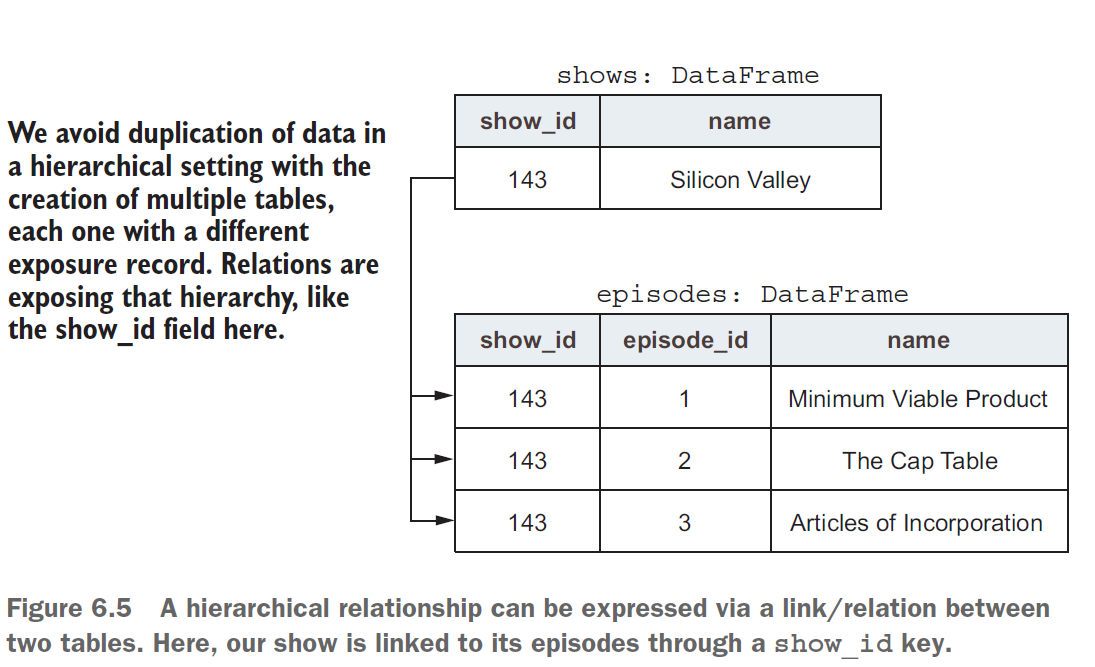

### If we want to avoid data duplication keep the relationship information and have a single table then we can and should use the data frame's complex columns

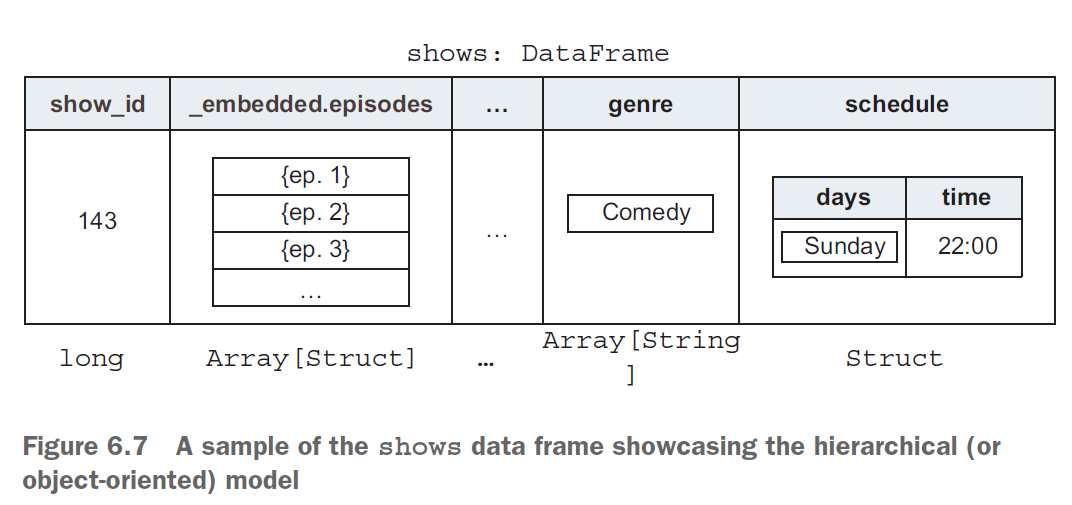


)


In [75]:
#Exlpoding the _embedded.episodes into 53 distinct records

episodes = shows.select("id",F.explode("_embedded.episodes").alias("episodes"))

episodes.show(5,truncate = 70)

episodes.count() #53

+---+----------------------------------------------------------------------+
| id|                                                              episodes|
+---+----------------------------------------------------------------------+
|722|{{{http://api.tvmaze.com/episodes/63861}}, 1985-09-14, 1985-09-15T0...|
|722|{{{http://api.tvmaze.com/episodes/63862}}, 1985-09-21, 1985-09-22T0...|
|722|{{{http://api.tvmaze.com/episodes/63863}}, 1985-09-28, 1985-09-29T0...|
|722|{{{http://api.tvmaze.com/episodes/63864}}, 1985-10-05, 1985-10-06T0...|
|722|{{{http://api.tvmaze.com/episodes/63865}}, 1985-10-19, 1985-10-20T0...|
+---+----------------------------------------------------------------------+
only showing top 5 rows



295

In [77]:
#Exploding a map using posexplode()

#BUild a map from two arrays
episode_name_id = shows.select(
F.map_from_arrays(
F.col("_embedded.episodes.id"), F.col("_embedded.episodes.name")
).alias("name_id")
)

# By position exploding, we create three columns: the position, the key, and the value of each element in our map have a record.
episode_name_id = episode_name_id.select(
F.posexplode("name_id").alias("position", "id", "name")
)

episode_name_id.show(5)

#Not :- Both explode() and posexplode() will skip any null values in the array or the map. If you want to have null as records, you can use explode_outer() or posexplode_outer() the same way


+--------+-----+--------------------+
|position|   id|                name|
+--------+-----+--------------------+
|       0|63861|      The Engagement|
|       1|63862|Guess Who's Comin...|
|       2|63863|      Rose the Prude|
|       3|63864|          Transplant|
|       4|63865|        The Triangle|
+--------+-----+--------------------+
only showing top 5 rows



In [79]:
#Collecting our results back into an array

collected = episodes.groupby("id").agg(
F.collect_list("episodes").alias("episodes")
)
collected.count()

collected.printSchema()

root
 |-- id: long (nullable = true)
 |-- episodes: array (nullable = false)
 |    |-- element: struct (containsNull = false)
 |    |    |-- _links: struct (nullable = true)
 |    |    |    |-- self: struct (nullable = true)
 |    |    |    |    |-- href: string (nullable = true)
 |    |    |-- airdate: string (nullable = true)
 |    |    |-- airstamp: string (nullable = true)
 |    |    |-- airtime: string (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- image: struct (nullable = true)
 |    |    |    |-- medium: string (nullable = true)
 |    |    |    |-- original: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- number: long (nullable = true)
 |    |    |-- runtime: long (nullable = true)
 |    |    |-- season: long (nullable = true)
 |    |    |-- summary: string (nullable = true)
 |    |    |-- url: string (nullable = true)



In [80]:
#Creating a struct column using the struct function

struct_ex = shows.select(
F.struct(
F.col("status"), F.col("weight"), F.lit(True).alias("has_watched")
).alias("info")
)

struct_ex.show(1, False)

struct_ex.printSchema()

+-----------------+
|info             |
+-----------------+
|{Ended, 68, true}|
+-----------------+
only showing top 1 row

root
 |-- info: struct (nullable = false)
 |    |-- status: string (nullable = true)
 |    |-- weight: long (nullable = true)
 |    |-- has_watched: boolean (nullable = false)

